5/14/2020

this is a update of 6A where instead of predicting cell type, we predict gene expression


todo
- test different types of models

# 0. startup


In [1]:
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import itertools
from scipy.stats.stats import pearsonr

from collections import Counter, defaultdict
import time
from sklearn.preprocessing import OneHotEncoder

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
save_dir = '../data/processed/fig4_modelling'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
THRES=1

In [5]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal','GDSD0','GDSD3','GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

In [6]:
# hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
# hoco_annon = pd.read_table(hoco_annon_file,header=0)
# hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
# hoco_motif_t|o_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
# tfs = list(hoco_annon['Transcription factor'])

# 1. create representation of crms (numerical format)
- one hot encoding for each of downstream machine learning
- save in `networks/representations`
- see `crms_representation.ipynb`

2. activity by contact
what is the correlation between expression of a gene and 
- the number of unique loops it contains
- sum of read counts aggregated over all loops
- number of atac regions



In [10]:
# data_all['log_exp'] = np.log(np.array(exp_label)+1e-2)


In [11]:
# g = sns.jointplot("num_loop_counts", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_loop_counts']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_loop_counts.pdf'))

In [12]:
# g2 = sns.jointplot("num_loops", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_loops']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_loops.pdf'))

In [13]:
# g3 = sns.jointplot("num_atac_regions_loop", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_atac_regions_loop']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_atac_regions_loop.pdf'))

In [15]:
# g4 = sns.jointplot("num_atac_regions_pro", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_atac_regions_pro']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_atac_regions_pro.pdf'))

In [16]:
# %%time
# sns.pairplot(data_all[["num_loops", "num_loop_counts", "num_snp", "num_atac_regions"]], diag_kind="kde")#,kind="reg")
# plt.savefig(os.path.join(save_dir,'pairplot_main_count_feats.png'))

# 2. Machine learning expression



In [17]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing, metrics
from scipy import interp
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

##  1. Data preprocessing and importing

iteracte through and choose different feature versions to find best)

found comb >~ sep > prom > sum

In [18]:
save_prefix = 'comb_tf_only' # comb >~ sep > prom > sumd
data_type = 'comb'

In [19]:
%%time
data_all = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(normal_tissues)]
print(data_all.shape)
# filter for crms with data, 
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]
print(data_all.shape)


(421787, 686)
(156071, 686)
CPU times: user 48.6 s, sys: 15 s, total: 1min 3s
Wall time: 53.1 s


In [20]:
exp_label = list(data_all.exp.values)
exp_label_bin  = np.array((data_all.exp>THRES).values)



preprocess genes by converting into number

In [21]:
genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)

In [22]:
len(np.unique(genes_all))

15582

 preprocess tissues

In [23]:
tissue_labels = data_all.tissue.values
tissue_num_labels =  data_all.tissue.map(normal_tissues_dict).values
tissue_labels.shape

(156071,)

In [24]:
# pd.read_csv('../../networks/diffgene/all_no_thres/all_Air_crm_tissue.csv').shape

In [25]:
Counter(tissue_labels)

Counter({'Airway': 5771,
         'Astrocytes': 7990,
         'Bladder': 8771,
         'Colon': 10518,
         'Esophageal': 9587,
         'GDSD0': 9430,
         'GDSD3': 9587,
         'GDSD6': 8812,
         'GM12878': 9009,
         'HMEC': 7885,
         'Melanocytes': 6887,
         'Ovarian': 9670,
         'Pancreas': 8943,
         'Prostate': 10675,
         'Renal': 10208,
         'Thyroid': 9963,
         'Uterine': 12365})

In [26]:
data_all

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,NFE2_pro,NKX6-1_pro,ZIC1_pro,NFE2_loop,NKX6-1_loop,ZIC1_loop,E2F5_pro,E2F5_loop,ESR2_pro,ESR2_loop
A4GALT,Airway,5.435,45.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GNT,Airway,0.000,13.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAMP,Airway,43.710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AANAT,Airway,0.000,13.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABAT,Airway,0.125,21.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT,Uterine,9.000,42.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,Uterine,0.135,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11A,Uterine,0.035,16.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,Uterine,18.470,41.0,2.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
## only tfs
data_all.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

data_all.shape




(156071, 680)

In [29]:
# ## normal version
# data_all.drop('tissue',axis=1,inplace=True)
# data_all['gene_num'] = genes_num_all
   
# data_all.shape




In [31]:
# preprocessing, remove zero variance columns, and scale rest of columns 
    
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all)
data_all_varfilt_cols = data_all.columns[selector.get_support()]
print(data_all.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
print(data_all_varfilt.shape, data_all_norm.shape)


(156071, 680) (156071, 647) 647
(156071, 647) (156071, 647)


## 2A: Classification:
Random Forest, SVM, etc
### 2A.0: Random Forest basic testing:


In [406]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 80)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())
Counter(test_labels)

Training Features Shape: (117053, 647)
Training Labels Shape: (117053,)
Testing Features Shape: (39018, 647)
Testing Labels Shape: (39018,)


Counter({'Colon': 2573,
         'Ovarian': 2412,
         'GDSD3': 2466,
         'Pancreas': 2180,
         'Esophageal': 2372,
         'Uterine': 3193,
         'Bladder': 2189,
         'Airway': 1432,
         'Renal': 2545,
         'HMEC': 2021,
         'Melanocytes': 1744,
         'Thyroid': 2423,
         'GDSD0': 2365,
         'GM12878': 2285,
         'Astrocytes': 1982,
         'GDSD6': 2230,
         'Prostate': 2606})

In [407]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 47min 19s, sys: 36.3 s, total: 47min 56s
Wall time: 3min 53s


In [408]:
# fpr, tpr, thresholds = metrics.roc_curve(test_labels, rf_probs, pos_label=1)
# fig, ax = plt.subplots()
# ax.plot(fpr,tpr)
# plot_roc_curve(model, test_features, test_labels, multi_class='ovr') 

In [409]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.to_csv(os.path.join(save_dir, save_prefix+'_feature_importance.csv'))

# Display
fi.head(10)

,feature,importance
615,WT1_loop,0.026687
363,SP2_loop,0.026355
365,SP4_loop,0.022914
592,ZNF467_loop,0.020987
613,KLF15_loop,0.019383
486,FLI1_loop,0.016057
551,KLF12_loop,0.014745
244,EGR2_loop,0.014240
332,PATZ1_loop,0.012137
296,MAZ_loop,0.010055


In [410]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)
# # Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
print(roc_value)

0.5572299964119124
0.8940531638881369


In [411]:
test_labels_num = np.vectorize(normal_tissues_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [412]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(model.classes_[i], roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), rf_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print('micro average', roc_auc["micro"])

Airway 0.8868062390697594
Astrocytes 0.9035227567602973
Bladder 0.8919894199211719
Colon 0.8947733720964519
Esophageal 0.8893575942251921
GDSD0 0.8903728752867662
GDSD3 0.8717358937758372
GDSD6 0.9182989883618708
GM12878 0.9405741330141495
HMEC 0.8621374438573639
Melanocytes 0.8955204281903464
Ovarian 0.8991593134783203
Pancreas 0.8769783370880986
Prostate 0.9055523713897967
Renal 0.8724497444270344
Thyroid 0.892067356504086
Uterine 0.9202863949816953
micro average 0.9020387205585405


In [413]:
normal_tissues_dict

{'Airway': 0,
 'Astrocytes': 1,
 'Bladder': 2,
 'Colon': 3,
 'Esophageal': 4,
 'GDSD0': 5,
 'GDSD3': 6,
 'GDSD6': 7,
 'GM12878': 8,
 'HMEC': 9,
 'Melanocytes': 10,
 'Ovarian': 11,
 'Pancreas': 12,
 'Prostate': 13,
 'Renal': 14,
 'Thyroid': 15,
 'Uterine': 16}

In [414]:
# saving
auc_df = pd.DataFrame.from_dict({'tissue':list(model.classes_)+['micro'],'LOO-AUROC': list(roc_auc.values())},orient='columns')
auc_df.to_csv(os.path.join(save_dir, save_prefix+'_auc_tissue.csv'))



In [415]:
# saving tpr 
pd.DataFrame.from_dict({'fpr':fpr["micro"],'tpr': tpr["micro"]},orient='columns').to_csv(os.path.join(save_dir, save_prefix+'_auc_curve_values.csv'))

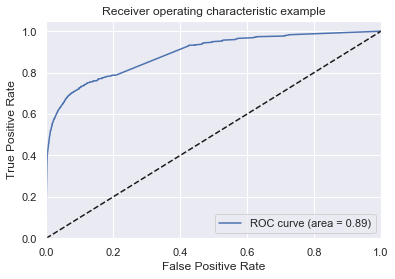

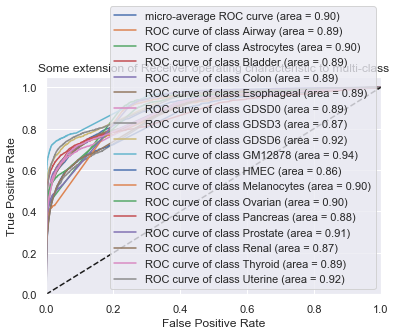

In [416]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [417]:
np.std(list(roc_auc.values()))

0.018412228103257797

In [418]:
conf_mat = confusion_matrix(test_labels, rf_predictions)
df_confmat = pd.DataFrame(conf_mat, index = model.classes_,
                  columns = model.classes_)
display(df_confmat)

,Airway,Astrocytes,Bladder,Colon,Esophageal,GDSD0,GDSD3,GDSD6,GM12878,HMEC,Melanocytes,Ovarian,Pancreas,Prostate,Renal,Thyroid,Uterine
Airway,713,7,59,14,25,39,55,30,17,54,8,5,20,238,31,10,107
Astrocytes,16,817,15,10,14,36,20,17,36,20,20,13,5,885,11,9,38
Bladder,28,8,1231,16,29,53,59,39,21,40,11,12,28,378,25,11,200
Colon,15,13,21,1492,70,17,30,16,32,18,10,41,33,439,102,157,67
Esophageal,28,8,28,61,1354,18,30,16,14,27,11,83,66,349,160,49,70
GDSD0,36,14,63,13,13,1345,94,59,20,62,13,27,15,466,20,13,92
GDSD3,50,11,58,13,22,157,1158,85,23,115,10,22,22,587,19,18,96
GDSD6,25,12,47,12,19,79,77,1365,26,46,16,10,12,414,18,13,39
GM12878,20,16,20,8,23,18,17,29,1569,11,11,14,8,434,30,13,44
HMEC,53,14,93,13,27,134,183,56,20,861,7,12,33,400,37,10,68


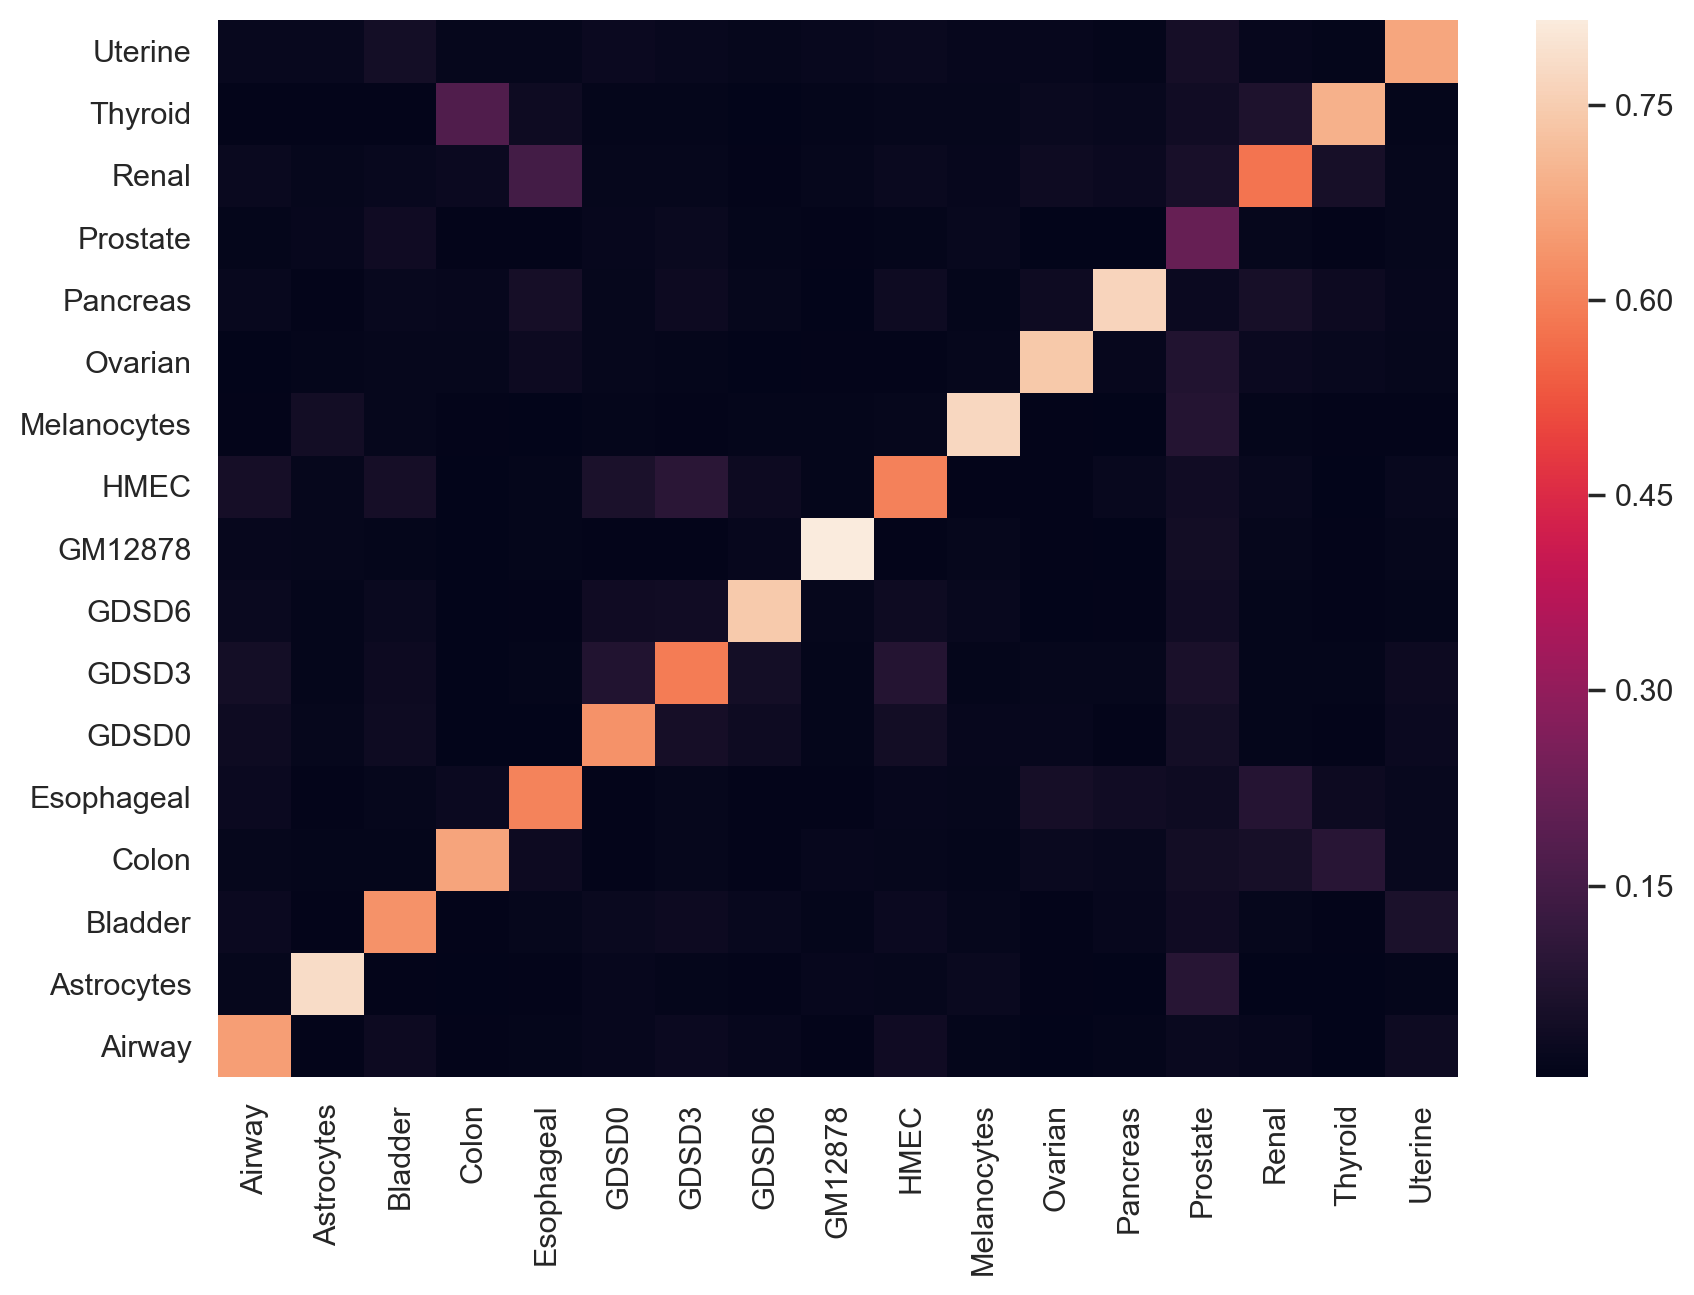

In [419]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(10,7),dpi=200)

ax = sns.heatmap(df_confmat/df_confmat.sum(axis=0), annot=False)
ax.set_ylim(0,len(df_confmat))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, save_prefix + '_df_confmat.pdf'),pad_inches=0.4)

### 2A.1 - testing amount of data



In [420]:
# def test_data_amt(data_mat, label_arr, perc_acc, )

In [ ]:
%%time
tot_data = len(data_all_norm)
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm[chosen_data_idx,:], 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)


0.005 780 0.7549947042533854
0.01 1560 0.7519477109679623
0.02 3121 0.774609297159982
0.04 6242 0.8183147728046894
0.08 12485 0.8405256923351875
0.16 24971 0.8445235982016381
0.25 39017 0.8538302122074904
0.32 49942 0.8623398896617002
0.5 78035 0.8756979172922983
0.75 117053 0.8841522574773416


In [ ]:
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, save_prefix+'_eval_df.csv'))

In [231]:

data_chosen

array([[6.72013936e-05, 6.09396059e-01],
       [5.85279991e-03, 2.87529684e-01],
       [3.37478531e-05, 2.31692446e-01],
       ...,
       [8.46639455e-05, 6.21141133e-01],
       [6.37677457e-06, 8.69392208e-01],
       [2.94312672e-06, 5.04460561e-02]])

In [327]:
# %%time
# rna info only
tot_data = len(data_all_norm)
column_chosen =[0,data_all_norm.shape[1]-1] # exp, num_gene
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    data_chosen = data_all_norm[chosen_data_idx,:]
    data_chosen = data_chosen[:,column_chosen].reshape((chosen_data_len, len(column_chosen)))

    train_features, test_features, train_labels, test_labels = train_test_split(data_chosen, 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, 'rna_eval_df.csv'))

0.005 166 0.5
0.01 332 0.4939747826213819
0.02 664 0.4983320747002378
0.04 1329 0.4854180617596844
0.08 2659 0.48552990531581025
0.16 5318 0.4803355500260448
0.25 8310 0.45920928930229304
0.32 10637 0.453524579235364
0.5 16621 0.4440088973902732
0.75 24932 0.42161237176574873
1 33243 0.4247720815122859


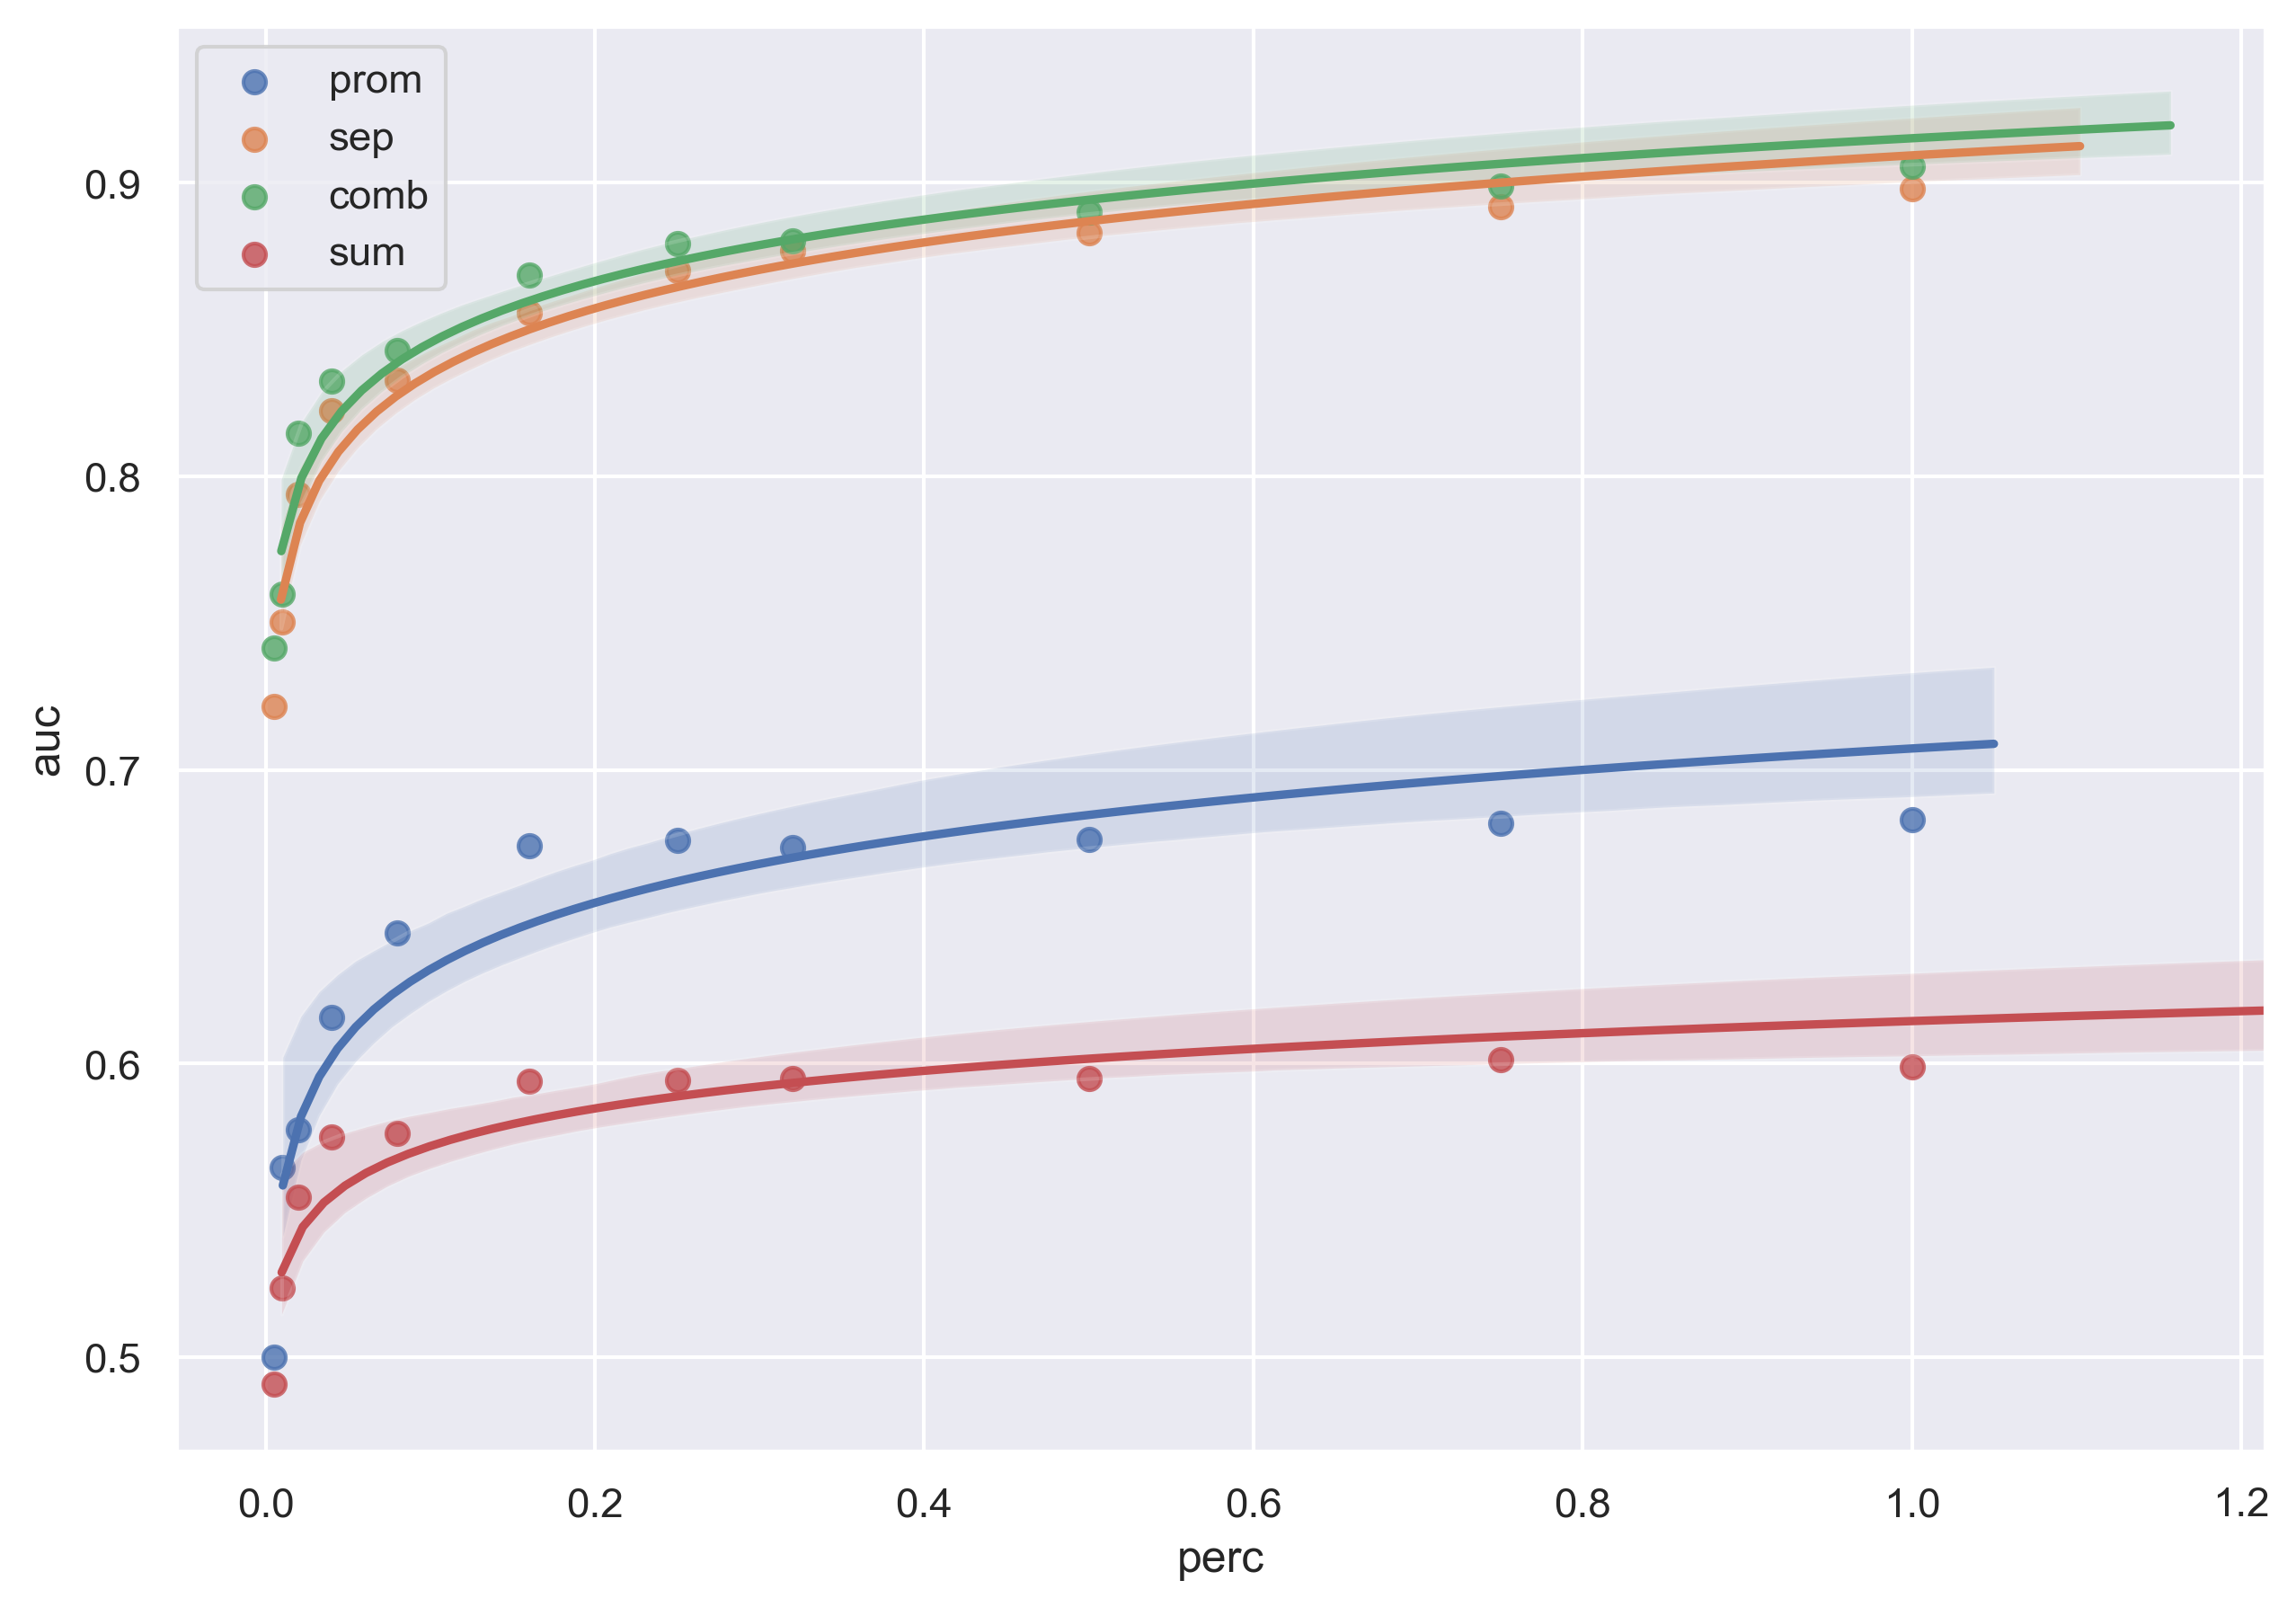

In [185]:
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
# type_to_legend_mapping = {
#     'sep':a
# }
for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_')[0]
    eval_df = pd.read_csv(filepath)
    sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type.pdf'))

fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label='tf_with_hichip')

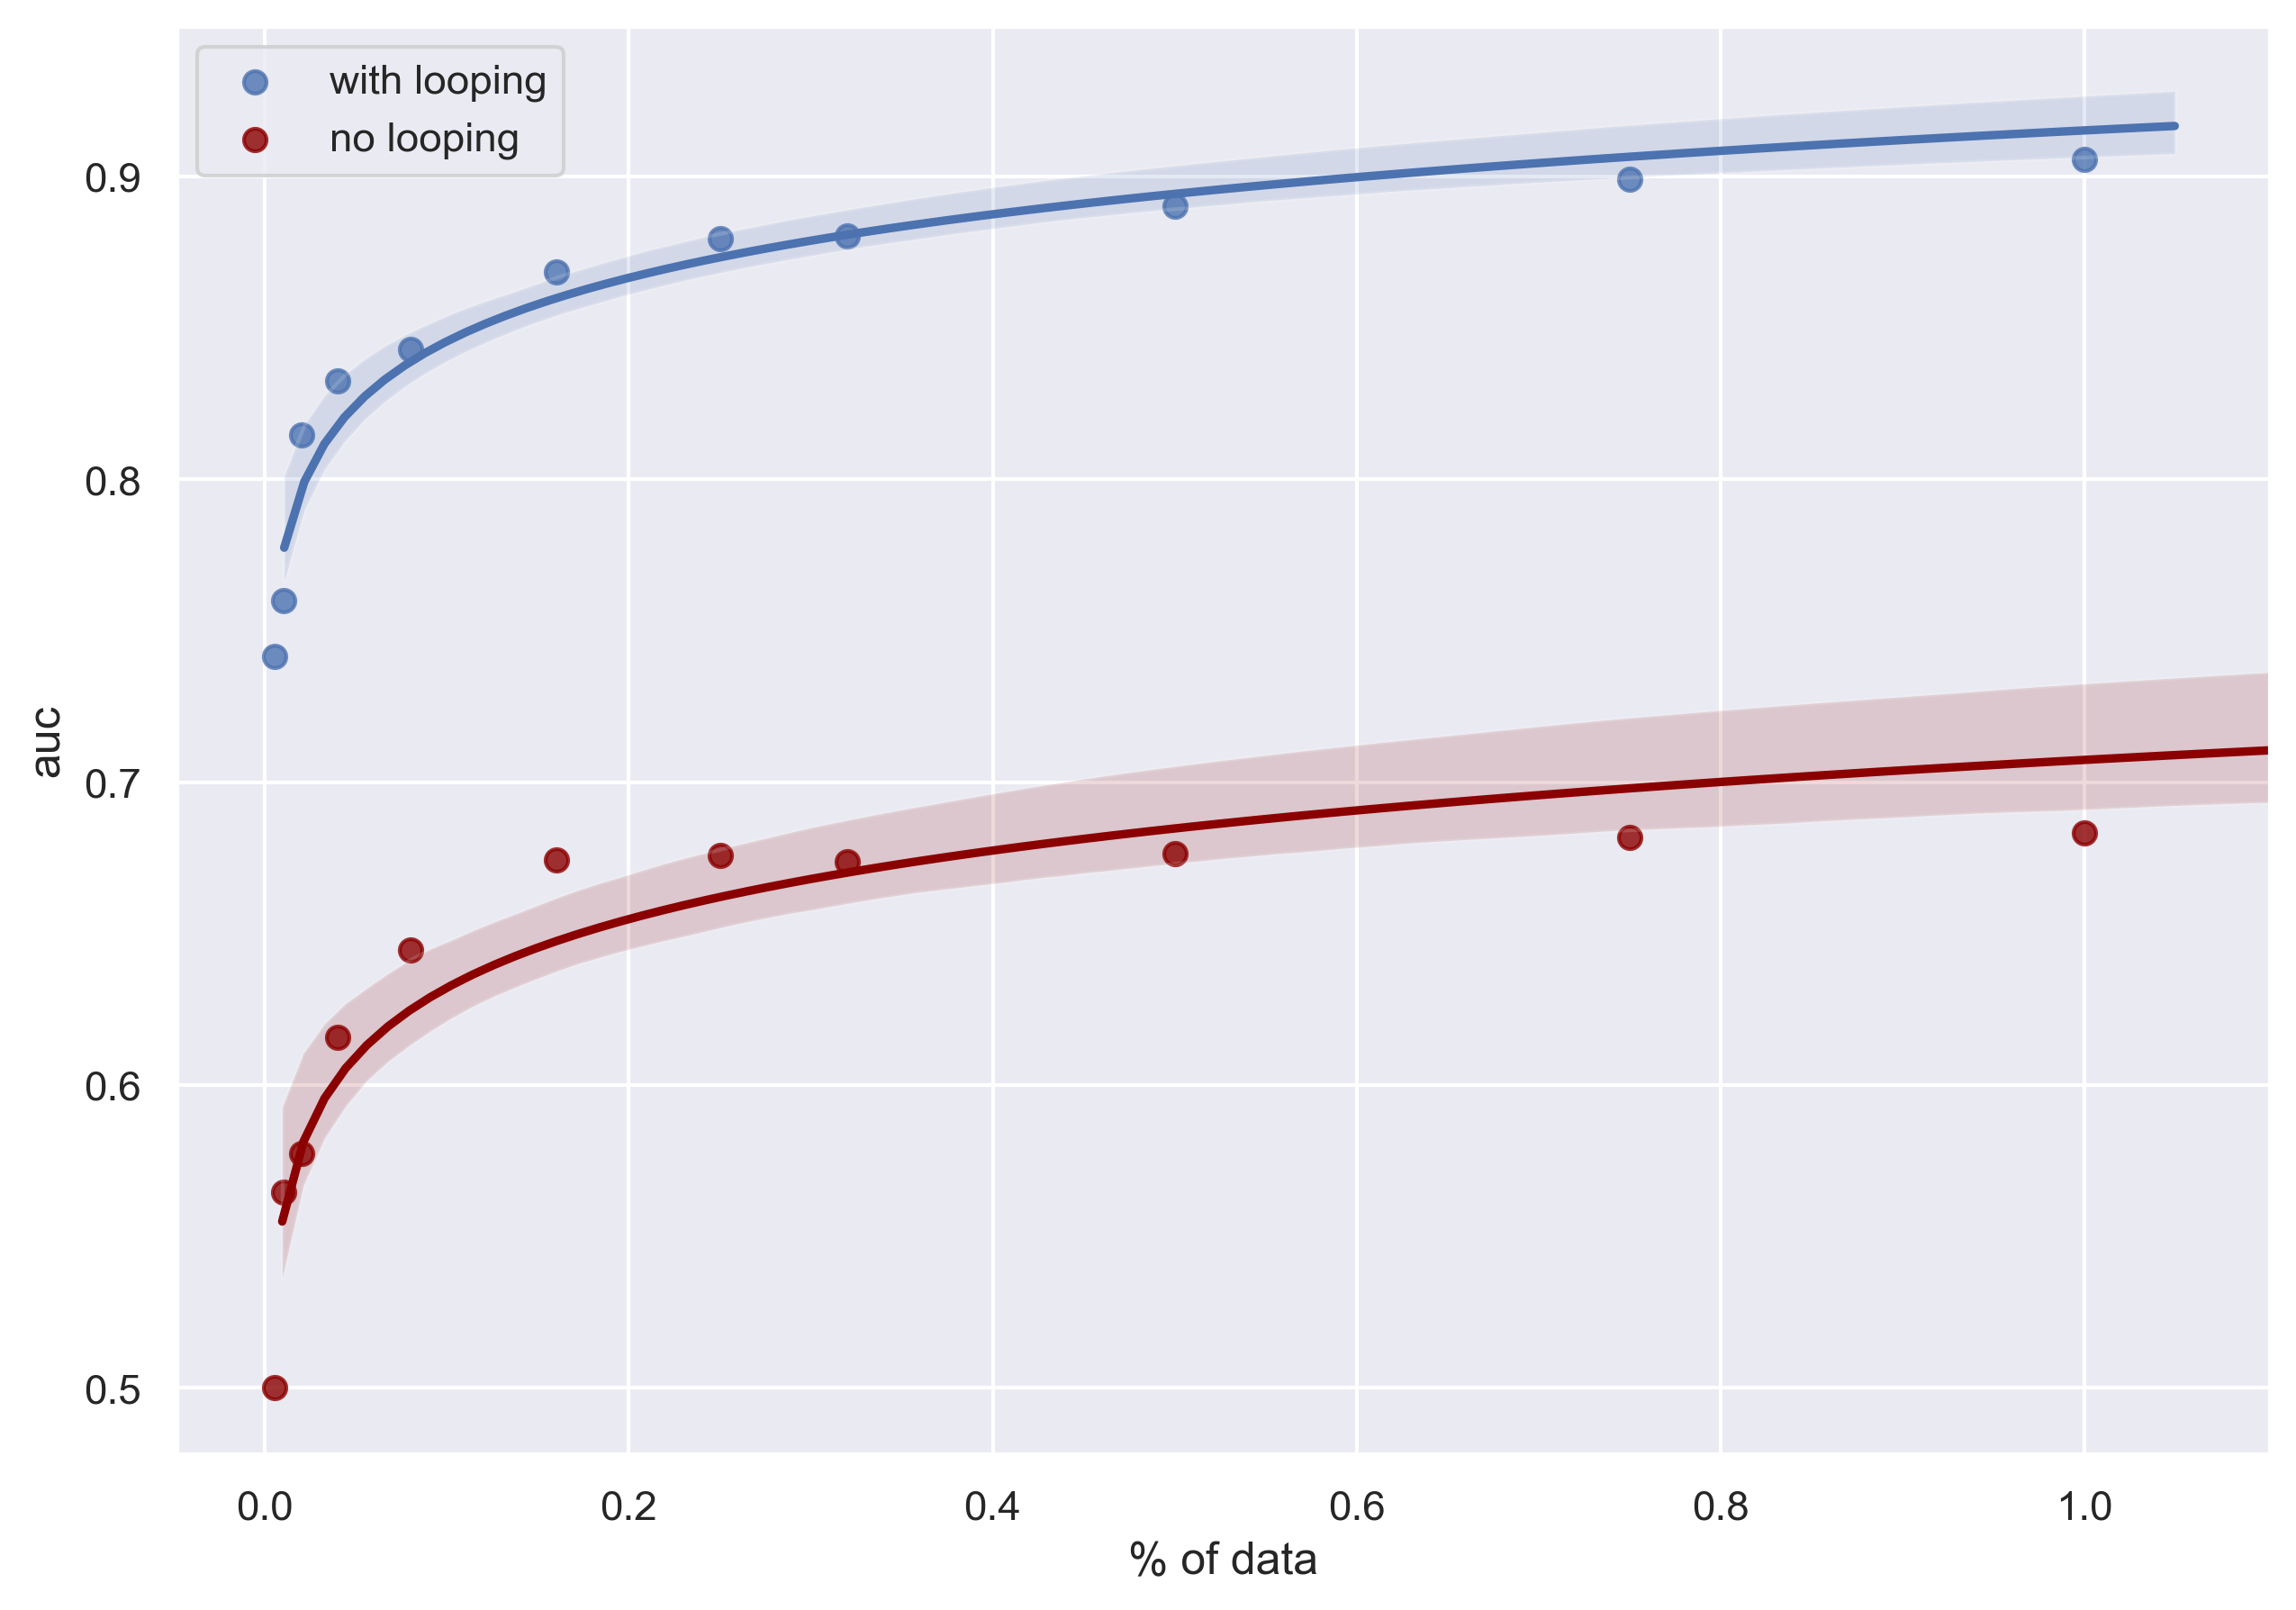

In [329]:
# sns.lineplot(x="perc", y="roc", data= pd.DataFrame.from_dict({'perc':perc_arr, 'roc':roc_arr}, orient='columns'))

comb_eval_df = pd.read_csv(os.path.join(save_dir, 'comb_eval_df.csv'))
prom_eval_df = pd.read_csv(os.path.join(save_dir, 'prom_eval_df.csv'))

fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=comb_eval_df,
           logx=True,ax=ax,label='with looping')
sns.regplot(x="perc", y="auc",data=prom_eval_df,
           logx=True,ax=ax,color='darkred',label='no looping')
ax.legend()
ax.set_xlabel('% of data')
fig.savefig(os.path.join(save_dir, '6A_eval_data_type_looping.pdf'))

In [291]:
prom_eval_df


,Unnamed: 0,perc,auc
0,0,0.005,0.500000
1,1,0.010,0.564706
2,2,0.020,0.577348
3,3,0.040,0.615764
4,4,0.080,0.644511
5,5,0.160,0.674250
6,6,0.250,0.675957
7,7,0.320,0.673638
8,8,0.500,0.676445
9,9,0.750,0.681876


(45855, 3)


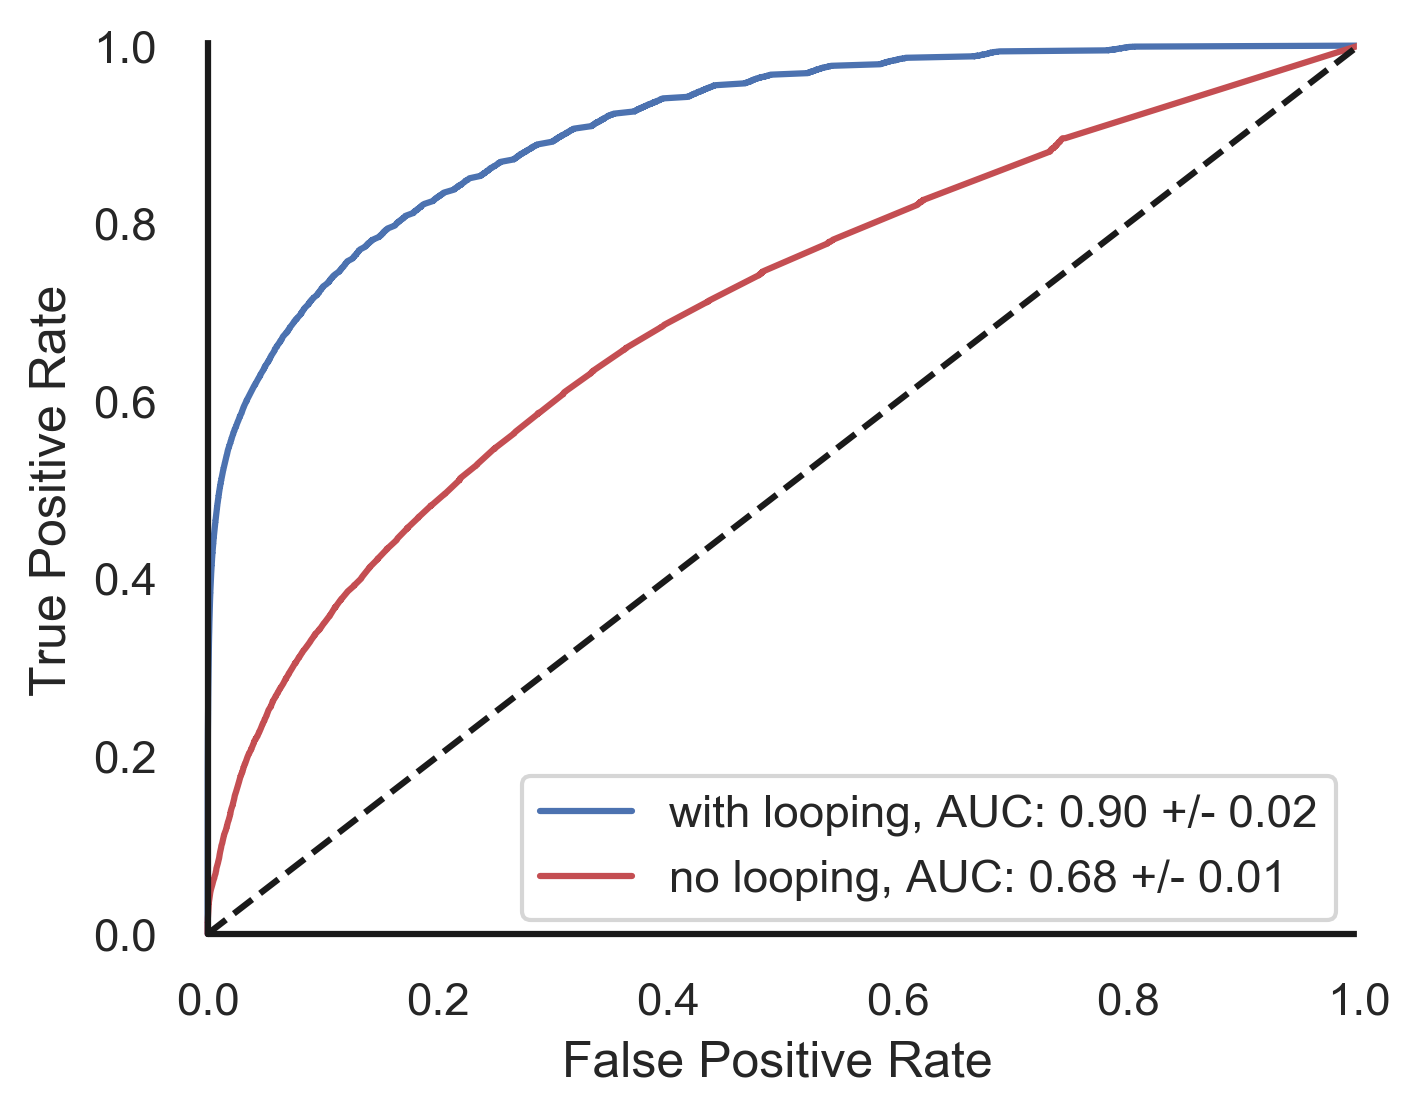

In [334]:
comb_auc_df = pd.read_csv(os.path.join(save_dir, 'comb_auc_curve_values.csv'))
prom_auc_df = pd.read_csv(os.path.join(save_dir, 'prom_auc_curve_values.csv'))
print(comb_auc_df.shape)
# with plt.style.context("seaborn-white"):
#     plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(5,4),dpi=300)
ax.set_facecolor('white')
ax.plot(comb_auc_df['fpr'], comb_auc_df['tpr'],'b-',label='with looping, AUC: 0.90 +/- 0.02')
ax.plot(prom_auc_df['fpr'], prom_auc_df['tpr'],'r-',label='no looping, AUC: 0.68 +/- 0.01')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim(-0.01,1)
ax.set_ylim(-0.01,1.01)

ax.plot([0, 1.1], [0, 0], 'k')
ax.plot([0, 0], [0, 1.1], 'k')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# sns.scatterplot(x="fpr", y="tpr",data=comb_auc_df,
#                 marker=False,'-',
#            ax=ax,label='with looping')
# sns.scatterplot(x="fpr", y="tpr",data=prom_auc_df,
#                 marker=False,'-',
#            ax=ax,color='darkred',label='no looping')
ax.legend(loc='lower right',facecolor='white')
fig.savefig(os.path.join(save_dir, 'auc_comb_pro.pdf'))

In [82]:
# %%time
# cv_results = cross_validate(clf, data_all_norm, labels_all_bin, groups = gene_groups, 
#                scoring=['accuracy', 'f1', 'roc_auc','precision', 'recall'])

In [119]:
# for key, list_res in cv_results.items():
#     print(key, "%.2f +/- %.2f" % (list_res.mean(), list_res.std()))

In [ ]:
# scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest per gene'))


### 2A.2 - test different models

### 2A - only atac or only hichip

In [ ]:
data_all_varfilt_cols

In [ ]:
atac_rna_foot_cols = data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')] + ['num_atac_regions']+ ['num_snp'] + ['log_exp'] + ['gene_num']
atac_rna_foot_col_idx = list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')])[0]) + list(np.where(data_all_varfilt_cols=='num_atac_regions')[0])+ list(np.where(data_all_varfilt_cols=='num_snp')[0])
atac_rna_foot_col_idx+=     list(np.where(data_all_varfilt_cols=='log_exp')[0])
atac_rna_foot_col_idx+=     list(np.where(data_all_varfilt_cols=='gene_num')[0])

len(atac_rna_foot_col_idx)
    

In [ ]:
hichip_only_cols = ['num_loop_counts', 'num_loops']
hichip_only_col_idx = list(np.where(data_all_varfilt_cols=='num_loop_counts')[0])+list(np.where(data_all_varfilt_cols=='num_loops')[0])



In [ ]:
atac_only_cols = ['num_atac_regions']
atac_only_col_idx = list(np.where(data_all_varfilt_cols=='num_atac_regions')[0])


In [ ]:
rna_only_cols = ['log_exp', 'gene_num']
rna_only_col_idx = list(np.where(data_all_varfilt_cols=='log_exp')[0])+list(np.where(data_all_varfilt_cols=='gene_num')[0])


In [ ]:
foot_cols = list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')]) + list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])
foot_col_idx = list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')])[0]) 
foot_col_idx+=   list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])[0]) 
len(foot_col_idx)
    

In [ ]:
all_indices = list(range(len(data_all_varfilt_cols)))

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


In [ ]:
test_labels_num = np.vectorize(tissue_to_num_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [ ]:
indices_to_test = [all_indices, hichip_only_col_idx, rna_only_col_idx, atac_only_col_idx, foot_col_idx, atac_rna_foot_col_idx]
test_name = ['All', 'HiChIP', 'RNA', 'ATAC', 'footprinting+looping', 'RNA+ATAC+footprinting']

In [ ]:
train_features[:,hichip_only_col_idx].shape

In [ ]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['data_type', 'fpr','tpr','auc'])
result_model_dict = {}
# Train the models and record the results
for idx_list, name in zip(indices_to_test, test_name):
    print(name)
    model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0).fit(train_features[:, idx_list], train_labels)
    yproba = model.predict_proba(test_features[:, idx_list])

    # get micro roc-auc for each type of data
    fpr, tpr, _ = roc_curve(test_labels_bin.ravel(),  yproba.ravel())
    
    
    auc = roc_auc_score(test_labels, yproba, multi_class='ovo')
    print(auc)
    result_model_dict[name] = model
    result_table = result_table.append({'data_type':name, #'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the data_type as index labels
result_table.set_index('data_type', inplace=True)

In [ ]:
result_table.reset_index(inplace=True)
result_table.at[4,'data_type']= 'footprinting+looping'
result_table.set_index('data_type',inplace=True)

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# 4 Clustering

Dimensionality reduction 

In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [40]:
groups_dict = {'Airway':'purple',
 'Astrocytes':'blue',
 'Bladder':'purple',
 'Colon':'green',
 'Esophageal':'green',
 'GDSD0':'purple',
 'GDSD3':'purple',
 'GDSD6':'purple',
 'GM12878':'grey',
 'HMEC':'purple',
 'Melanocytes':'blue',
 'Ovarian':'green',
 'Pancreas':'green',
 'Prostate':'purple',
 'Renal':'green',
 'Thyroid':'green',
 'Uterine':'purple'}


In [64]:
data_all_norm = pd.DataFrame(data_all_norm, columns = data_all_varfilt_cols)
data_all_norm = pd.concat([data_all_norm, pd.Series(tissue_labels,name='tissue'),pd.DataFrame(genes_all,columns=['gene'])],axis=1)
data_all_norm['group'] = data_all_norm.tissue.map(groups_dict)

In [65]:
data_all_norm[:5]

,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,BACH1_pro,...,TFAP2B_pro,ZNF382_pro,MYOD1_loop,TFAP2B_loop,ZNF382_loop,E2F5_pro,E2F5_loop,tissue,gene,group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,A4GALT,purple
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,A4GNT,purple
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,AAMP,purple
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,AANAT,purple
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,ABAT,purple


### 4A PCA

In [63]:
n_comp = 50
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(data_all_norm[data_all_varfilt_cols].values)


In [45]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)

Explained variation per principal component: [0.12118858 0.02776559 0.02297477 0.01892142 0.01361862 0.01252915
 0.01203427 0.01074752 0.00999607 0.00981497 0.00936699 0.00911226
 0.0085071  0.00801248 0.00766864 0.00732615 0.00717491 0.00691127
 0.00670418 0.00639685 0.00607562 0.0060535  0.00578836 0.00577663
 0.0056744  0.00550037 0.00545777 0.00523971 0.00515697 0.0051117
 0.0048919  0.00472565 0.00466125 0.00458997 0.00449899 0.00444271
 0.00439504 0.00436403 0.00431604 0.00419905 0.0041519  0.00399933
 0.00395339 0.0038782  0.00382413 0.00379712 0.00370369 0.00367554
 0.00364541 0.00359453]


0.47591467916220404

In [67]:
for i in range(n_comp):
    data_all_norm['pc_'+str(i+1)] = pca_result[:,i]


In [113]:
data_all_norm.shape

(156071, 700)

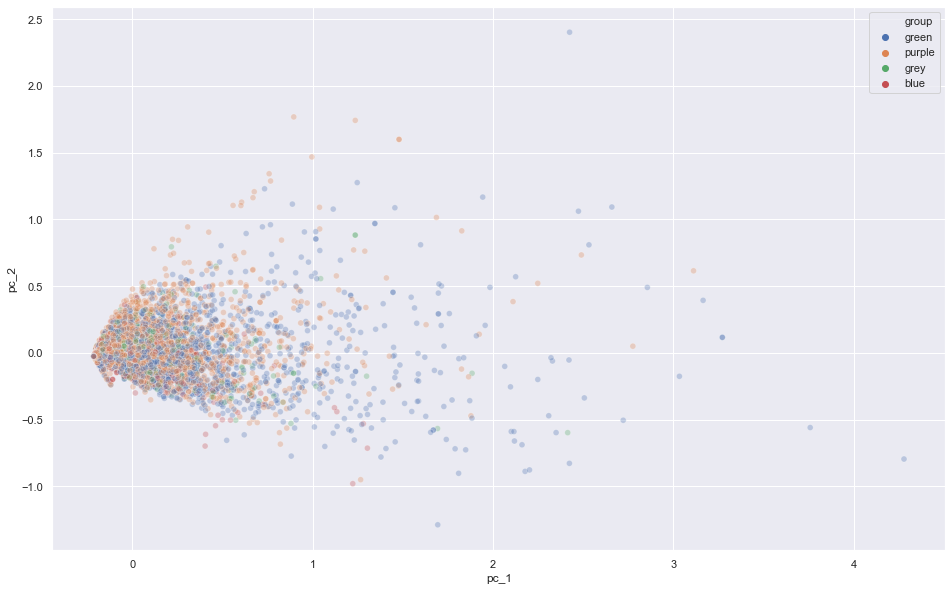

In [69]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pc_1', y='pc_2',
    hue="group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm.loc[idx_choice],#df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_pca12.png'))

In [70]:
# figure out what's responsible for a pc space
pc2_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_2_coeff':pca.components_[1]})#,orient='index')
pc2_df['pc_2_coeff_abs'] = abs(pc2_df['pc_2_coeff'])
pc2_df.sort_values('pc_2_coeff_abs',ascending=False)

,features,pc_2_coeff,pc_2_coeff_abs
286,JUNB_loop,0.188203,0.188203
285,JUN_loop,0.173068,0.173068
255,FOS_loop,0.160287,0.160287
258,FOSL2_loop,0.155020,0.155020
257,FOSL1_loop,0.151815,0.151815
...,...,...,...
516,AR_pro,0.000007,0.000007
529,POU3F2_pro,0.000005,0.000005
527,OLIG2_pro,0.000004,0.000004
114,NR6A1_pro,0.000002,0.000002


In [71]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 1000)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x='pc_1', y='pc_2',
#     hue="gene",
# #     palette=sns.color_palette("hls", 10),
#     data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
#     legend="brief",
#     alpha=0.3
# )
# plt.savefig(os.path.join('networks/representations', 'dimred_pca12_gene.png'))

### 4B: tsne

In [72]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
data_all_norm_df_subset = data_all_norm.loc[idx_choice]

In [73]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[idx_choice,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.025s...
[t-SNE] Computed neighbors for 10000 samples in 4.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.941071
[t-SNE] KL divergence after 300 iterations: 2.778620
t-SNE done! Time elapsed:

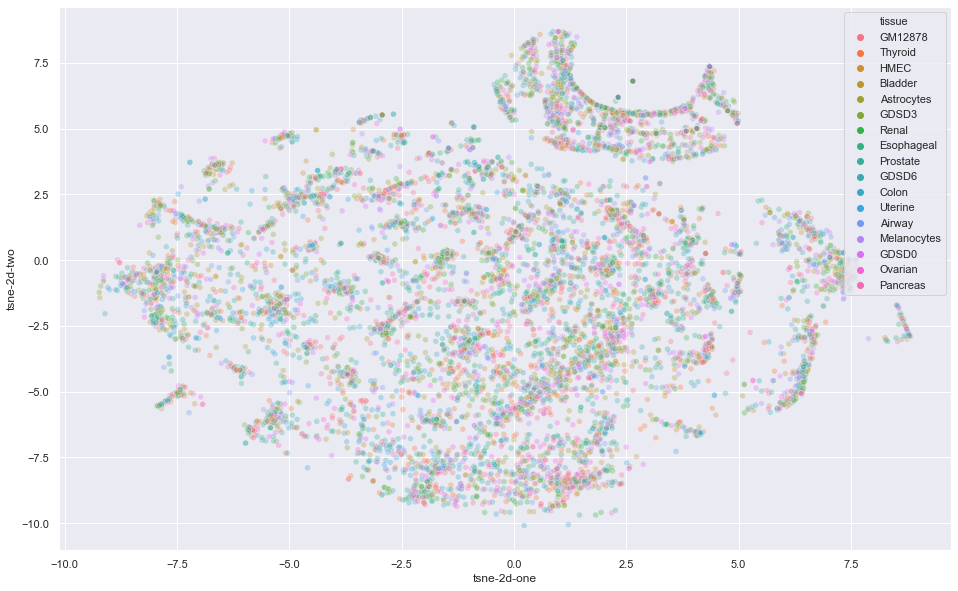

In [74]:
data_all_norm_df_subset['tsne-2d-one'] = tsne_results[:,0]
data_all_norm_df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2.png'))

### 4C UMAP

In [75]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_result[:,:])
embedding.shape

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


CPU times: user 22.2 s, sys: 255 ms, total: 22.4 s
Wall time: 18.3 s


(10000, 2)

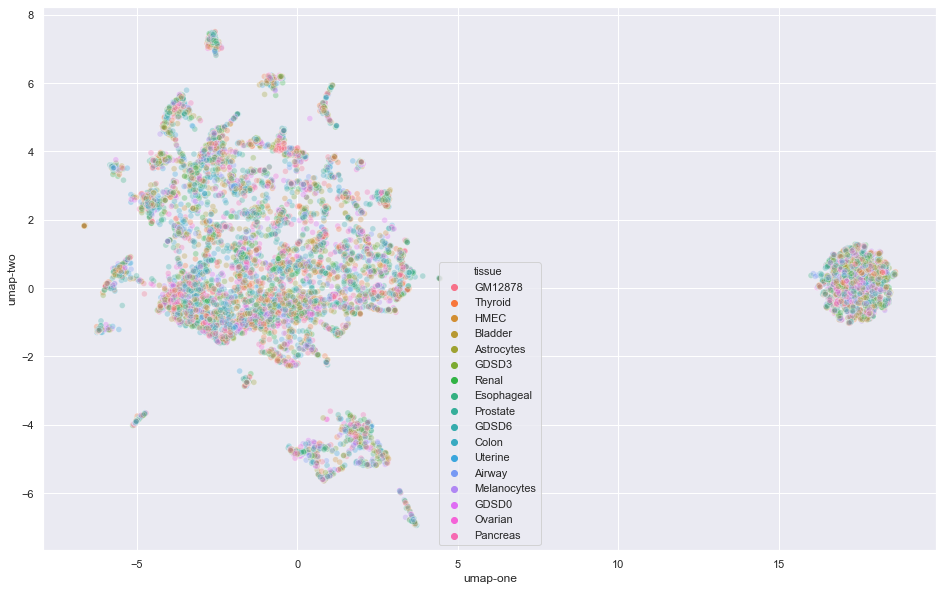

In [76]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap.png'))

In [96]:
x = gene_variance_df.iloc[0,:]
print(x)
np.sqrt(x['umap-one']**2 + x['umap-two']**2)

umap-one    4.889963
umap-two    1.436130
Name: A2ML1, dtype: float32


5.096489525527799

In [98]:
gene_variance_df = data_all_norm_df_subset.groupby('gene').agg({
    'umap-one':'std','umap-two':'std'
}).dropna()
gene_variance_df['sq_var'] = gene_variance_df.apply(lambda x: np.sqrt(x['umap-one']**2 + x['umap-two']**2),axis=1)
gene_variance_df.sort_values('sq_var',inplace=True)

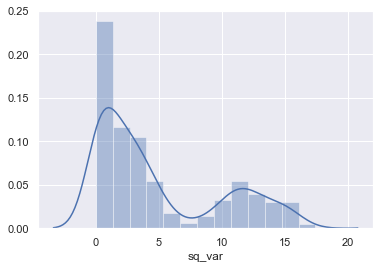

In [101]:
sns.distplot(gene_variance_df.sq_var)

In [109]:
low_var_genes = gene_variance_df.index[gene_variance_df.sq_var < 1]
med_var_genes = gene_variance_df.index[(gene_variance_df.sq_var >= 1)&(gene_variance_df.sq_var < 7) ]
high_var_genes = gene_variance_df.index[gene_variance_df.sq_var >= 7]
len(low_var_genes), len(med_var_genes), len(high_var_genes)

(648, 1013, 658)

In [110]:
for x in low_var_genes:
    print(x)

CNFN
TRRAP
RARRES1
IPO7
SF3B3
CTDSP2
TNFRSF8
GAL3ST4
RFX5
PRR26
BCR
SYT15
CCT6B
WIZ
HMMR
RAD52
RWDD2A
KRT83
PTGS1
TAF9B
EIF2AK4
UBALD1
DEXI
FASTKD2
PDCD5
KNOP1
DZIP1
CCDC78
EIF2D
OSR1
KCNE1
PLXNA1
PELI3
WWP2
LILRA6
ERGIC3
SPIRE1
PPM1D
TCF20
FAM102A
TEK
TSPAN2
ALPK2
CEACAM3
ATOH8
PLA2G12A
DPF1
LAMTOR5
LILRB4
PRSS3
EBLN2
CRLF1
RPUSD1
ZKSCAN8
TBC1D21
SPRY1
OSBPL8
METTL8
DOLK
HCST
AANAT
IRAK1
FANCD2
DTX2
SCO1
ANGPT1
PDCD6IP
LPCAT2
EAF2
TMEM95
OLFM4
DAZAP2
DNMBP
MSS51
SRSF2
CHN2
ZSWIM5
INO80D
DENND5B
C2CD2L
IQCB1
ZNF543
OR5B21
MPZ
SCUBE2
HABP2
CORIN
WSCD2
ARIH2
KRTAP19-3
HCLS1
SPDYE2
ITPR2
GKN2
SLC45A2
MSRA
ZSCAN32
PPP1R14D
SPCS1
BTG2
ADAMTS3
FAM166B
TADA1
CLDN16
PARP4
TSSK2
SMC1B
OXTR
YIPF3
TRAPPC2
FXN
VCPKMT
MASTL
SEMA6B
HNRNPA0
PHF5A
TOP2B
ABHD12
TRPV6
CR1
PRKCG
VDAC2
MRPS23
EIF2S3
PYDC1
IL1A
STK10
LATS1
CD3D
ATP6V1C2
PRKCH
USP21
TSPAN16
CSRP3
FKBP1A
ARSA
MMRN2
TRAPPC6A
RILPL1
MED17
OPN1MW2
GORAB
TAF7
PLA2G2E
DIO1
PIM3
HSPD1
SPRR2D
COMMD10
ZNF304
IFT20
NUTM1
WDR90
RBAK-RBAKDN
ANKRD13C
TM

In [85]:
# cluster_one = sorted(set(data_all_norm_df_subset[data_all_norm_df_subset['umap-one']>10]['gene'].values))
# print(len(cluster_one))
# for x in cluster_one:
#     print(x)

1876
A4GALT
AADACL4
AAMDC
AAR2
AARS2
AARSD1
ABCA13
ABCA4
ABCB1
ABCB5
ABCC1
ABCC4
ABCC8
ABCD1
ABCG1
ABCG2
ABHD13
ABHD16B
ABHD17A
ABHD2
ABHD3
ABI3BP
ACAT2
ACER1
ACHE
ACKR2
ACOT1
ACOT8
ACOX3
ACOXL
ACSL4
ACSM2A
ACTG2
ACTR1B
ACTR8
ACTRT3
ACVR1
ADAM10
ADAM17
ADAM19
ADAM28
ADAM9
ADAMDEC1
ADAMTS1
ADAMTS12
ADAMTS14
ADAMTS17
ADAMTS8
ADD3
ADH5
ADHFE1
ADIPOR2
ADIRF
ADNP2
ADORA1
ADPRHL1
ADTRP
AEBP2
AFMID
AGFG2
AHCTF1
AHCY
AHCYL2
AHR
AIM2
AIMP1
AK1
AK5
AK7
AKAP12
AKAP7
AKAP9
ALDH1B1
ALDH3B1
ALG3
ALKBH7
ALOX15
ALX1
AMBN
AMIGO1
AMIGO2
ANKK1
ANKRD1
ANKRD17
ANKRD23
ANKRD34B
ANKRD42
ANKRD44
ANKRD45
ANKRD61
ANO4
ANO7
ANTXR1
ANTXR2
AOC3
AOX1
AP3B2
AP3M1
AP3M2
AP4B1
AP5M1
APAF1
APBA1
APIP
APOBEC3G
APOE
APOL1
APOL3
APP
APPL2
AQP11
AQP5
AQP6
ARAF
ARF3
ARFGEF1
ARG2
ARHGAP18
ARHGAP22
ARHGAP31
ARHGAP5
ARHGEF1
ARHGEF38
ARID4B
ARL4A
ARMC3
ARNT
ARNTL
ARSI
ARSJ
ART4
ARX
ASAP1
ASCL4
ASGR1
ASIC1
ASPHD1
ASPHD2
ASRGL1
ASTE1
ATF1
ATF2
ATF7IP2
ATG7
ATP10D
ATP11C
ATP12A
ATP13A1
ATP2B1
ATP2B3
ATP2C1
ATP6V0C
ATP6V1H
ATP8B1
A

In [111]:
data_all_norm_df_subset['var_group'] = 'none'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(low_var_genes)]='low_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(med_var_genes)]='med_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(high_var_genes)]='high_var'

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

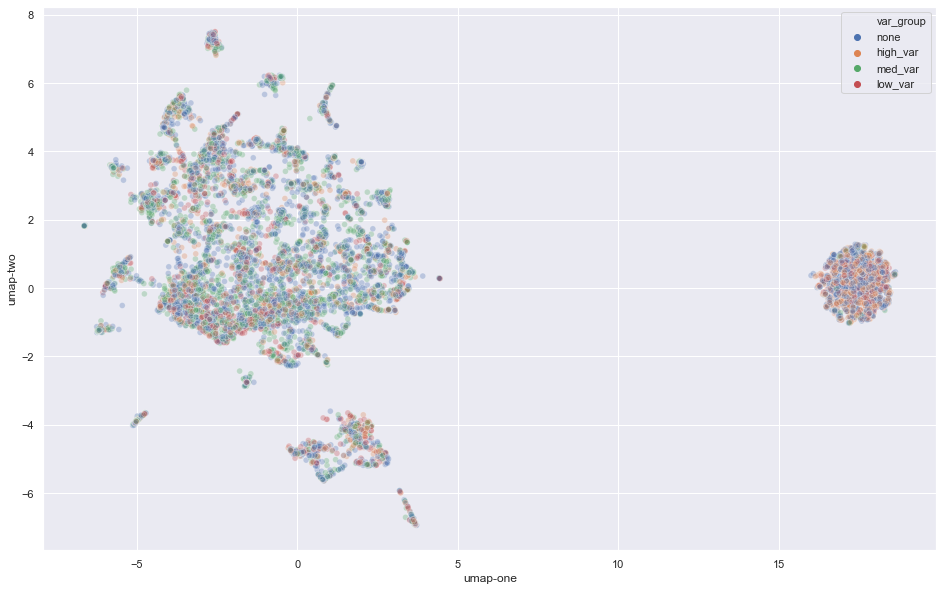

In [112]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="var_group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap_vargroup.png'))

# 5. pairwise correlation

In [119]:
pro_cols = [x for x in data_all_norm.columns.values if '_pro' in x]
loop_cols = [x for x in data_all_norm.columns.values if '_loop' in x]

In [125]:
data_all_norm_tf = data_all_norm[pro_cols+loop_cols]
data_all_norm_tf[data_all_norm.tissue=='GDSD6'].shape

(8812, 647)

In [126]:
%%time
# might take awhile
data_all_norm_tf_corr_GDSD6 = data_all_norm_tf[data_all_norm.tissue=='GDSD6'].corr()

CPU times: user 4.77 s, sys: 11.7 ms, total: 4.78 s
Wall time: 4.78 s


,AHR_loop,ARID5B_loop,ARNT_loop,ARNTL_loop,ATF1_loop,ATF2_loop,ATF3_loop,ATF4_loop,ATF6_loop,BACH1_loop,...,SALL4_loop,IKZF1_loop,LYL1_loop,PAX5_loop,SPIB_loop,TBX21_loop,MYOD1_loop,TFAP2B_loop,ZNF382_loop,E2F5_loop
AHR_pro,0.167396,-0.003806,0.019803,0.024617,-0.005476,-0.008128,0.006024,-0.007440,0.011404,0.003554,...,-0.003831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARID5B_pro,-0.004047,0.093680,-0.004665,0.009042,-0.005476,-0.000166,-0.006531,-0.007440,0.028528,0.003554,...,0.016066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARNT_pro,0.018378,-0.004662,0.114177,0.004717,-0.006708,-0.009957,0.002253,0.001876,0.006977,-0.000498,...,0.004786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARNTL_pro,0.005204,0.003697,-0.009772,0.128010,0.004529,-0.005590,0.016376,0.029518,0.012614,0.005312,...,0.014006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATF1_pro,0.006471,-0.006420,-0.007869,0.025221,0.216247,0.097445,0.111681,0.006236,0.006287,-0.002989,...,0.016879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBX21_pro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYOD1_pro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TFAP2B_pro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNF382_pro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
save_path = os.path.join(save_dir, save_prefix+'_GDSD6_tfcorr.csv')
print(save_path)
data_all_norm_tf_corr_GDSD6.loc[pro_cols,loop_cols].fillna(0).to_csv(save_path)

../data/processed/fig4_modelling/comb_tf_only_GDSD6_tfcorr.csv


In [135]:
os.path.join(save_dir, save_prefix+'_tfcorr.csv')

'../data/processed/fig4_modelling/comb_tf_only_tfcorr.csv'